# Initialisation

LIME Installation

In [2]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import random
import numpy as np
import matplotlib as plt
import warnings

warnings.filterwarnings("ignore")
from google.colab import data_table
# Display smart tables into colab ;-)
data_table.enable_dataframe_formatter()

import lime
from lime import lime_tabular

# Create a Regression Model & train it with the California data

Quickly train a model with the California dataset (given as sample when using colab)

In [10]:
train = pd.read_csv('/content/sample_data/california_housing_train.csv')
test = pd.read_csv('/content/sample_data/california_housing_test.csv')
all_data = pd.concat([train, test], axis=0)
print(all_data.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')


All numbers ?

In [53]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20000 non-null  float64
 1   latitude            20000 non-null  float64
 2   housing_median_age  20000 non-null  float64
 3   total_rooms         20000 non-null  float64
 4   total_bedrooms      20000 non-null  float64
 5   population          20000 non-null  float64
 6   households          20000 non-null  float64
 7   median_income       20000 non-null  float64
 8   median_house_value  20000 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


In [55]:
all_data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [16]:
scaler = StandardScaler()
# Function to prepare the data before modeling
def prepare_data(data, scale=True):
  names = data.columns
  if (scale == True):
    # Scale data ?
    scaled_data = scaler.fit_transform(data)
    data = pd.DataFrame(scaled_data, columns=names)
  X_features = names
  # Or select the features ...
  #X_features = ["median_income", "latitude", "longitude", "housing_median_age", "total_bedrooms", "total_rooms", "population", "households"] 
  y_label = ["median_house_value"] # Take the label
  X = data[X_features] # Take the features
  del X["median_house_value"] # remove the label
  y = data[y_label]
  # Create datasets for train & test
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  return x_train, x_test, y_train, y_test

# return value (un-scaled)
def get_value(val):
  result = scaler.inverse_transform([np.concatenate((np.zeros(8), val))])
  return result[0][8]

# Prepare the all dataset
x_train, x_test, y_train, y_test = prepare_data(all_data)

# Train & Test
model = RandomForestRegressor()
model.fit(x_train.values, y_train.values.reshape(-1))
print(f"Score / training data: {round(model.score(x_train, y_train)*100, 1)} %")
print(f"Score / test data: {round(model.score(x_test, y_test)*100, 1)} %")

Score / training data: 97.5 %
Score / test data: 80.9 %


In [17]:
# Predict all the value for the training dataset
y_train_predict = pd.DataFrame(model.predict(x_train))
y_train_predict

Output hidden; open in https://colab.research.google.com to view.

Display data (real results vs predicted results)

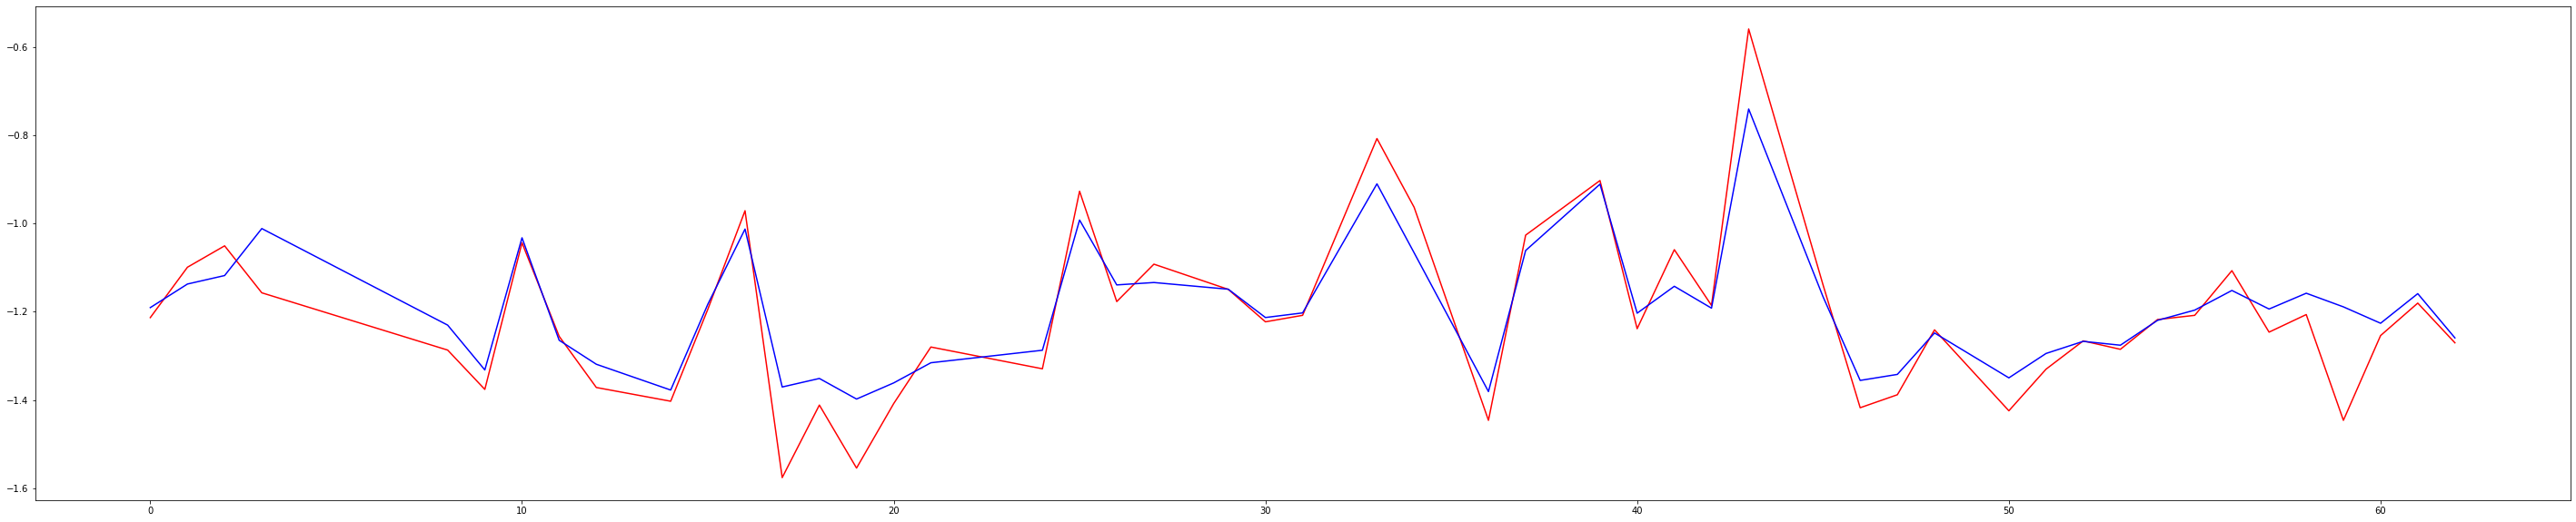

In [30]:
Y = y_train.copy()
Y["Prediction"] = y_train_predict.to_numpy()
Y.columns = ["Real", "Predict"]
Y = Y.sort_index()
Y["Id"] = Y.index
Y["Delta"] = Y["Real"] - Y["Predict"]
Y = Y.head(50)

plt.rcParams["figure.figsize"] = (50, 10)
Y["Real"].plot(color="#FF0000") # Red line
Y["Predict"].plot(color="#0000FF") # Blue line

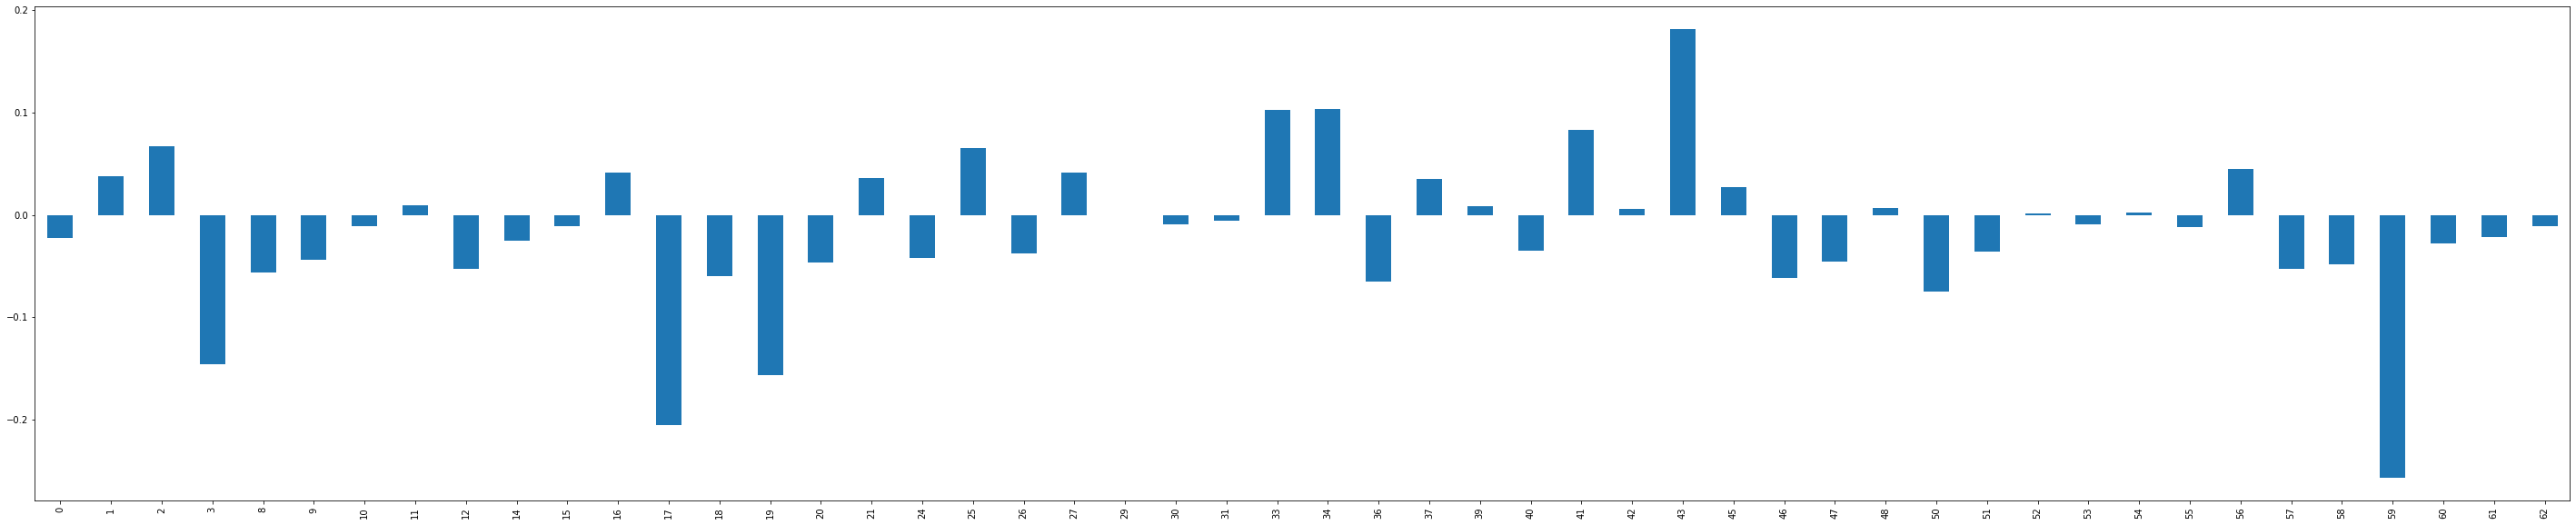

In [31]:
Y["Delta"].plot.bar() # Delta

In [19]:
Y.head(5)

,Real,Predict,Id,Delta
0,-1.213134,-1.199123,0,-0.014011
1,-1.098902,-1.149008,1,0.050106
2,-1.050440,-1.110351,2,0.059911
3,-1.156884,-1.008676,3,-0.148208
8,-1.286693,-1.237296,8,-0.049397


# LIME Stuff

In [32]:
explainer = lime_tabular.LimeTabularExplainer(x_train.to_numpy(), 
                                              mode="regression",  
                                              feature_names= list(x_train.columns)
                                              )

Function which display the LIME Explanations

In [42]:
def xai_display_for_value(idx):
  print("----------------------------------------------------")
  print("Index: ", idx)
  print("Scaled Prediction: ", y_train_predict.iloc[idx])
  print("Scaled Actual:     ", y_train.iloc[idx])
  print("Predicted value: ", get_value(y_train_predict.iloc[idx]))
  print("Real value: ", get_value(y_train.iloc[idx]))
  print("Delta (%): ", (get_value(y_train.iloc[idx]) - get_value(y_train_predict.iloc[idx])) * 100 / get_value(y_train.iloc[idx]) )

  explanation = explainer.explain_instance(x_train.iloc[idx], 
                                          model.predict, 
                                          num_features=len(list(x_train.columns)))
  explanation.show_in_notebook(show_table=True)
  return explanation

Just take a example (one row) ...

In [51]:
i = random.randint(1, len(x_train))
xai_display_for_value(i)

----------------------------------------------------
Index:  12247
Scaled Prediction:  0   -0.761813
Name: 12247, dtype: float64
Scaled Actual:      median_house_value   -0.890342
Name: 224, dtype: float64
Predicted value:  119052.01000000008
Real value:  104200.0
Delta (%):  -14.253368522073014


Other samples ...

In [ ]:
xai_display_for_value(1)
xai_display_for_value(1000)

Output hidden; open in https://colab.research.google.com to view.

Generate a bar chart of feature contribution for this data sample:

# Get the LIME results

In [46]:
expl = xai_display_for_value(1)

----------------------------------------------------
Index:  1
Scaled Prediction:  0    1.923631
Name: 1, dtype: float64
Scaled Actual:      median_house_value    1.758632
Name: 7766, dtype: float64
Predicted value:  429366.2399999999
Real value:  410300.0
Delta (%):  -4.6469022666341395


Returns LIME explanation as a list:
1.   first value of tuple is condition
2.   second value contribution of the feature value based on condition.


In [48]:
expl.as_list()

[('median_income > 0.47', 1.2105286311280485),
 ('latitude <= -0.79', 0.8663127017804445),
 ('0.53 < longitude <= 0.78', -0.18601783455962326),
 ('population <= -0.57', 0.1700758605340672),
 ('-0.84 < housing_median_age <= 0.03', -0.055667480769627416),
 ('-0.58 < total_bedrooms <= -0.25', -0.05216741340105752),
 ('-0.58 < households <= -0.23', 0.007839767845531052),
 ('-0.54 < total_rooms <= -0.24', 0.0005512754493286088)]

Generate a bar chart of feature contribution for this data sample:


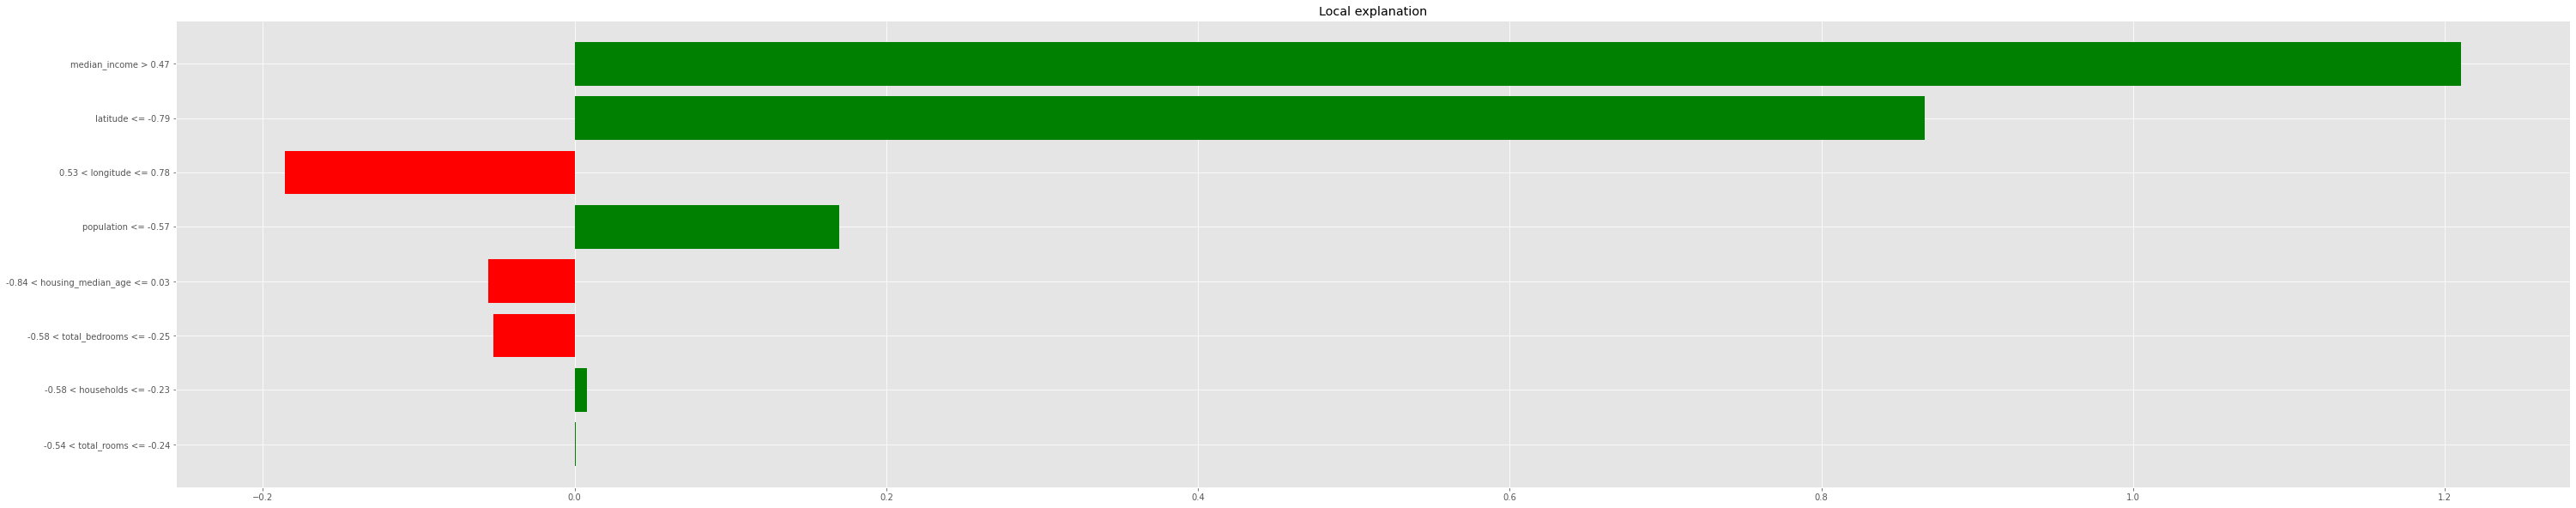

In [49]:
print ("Generate a bar chart of feature contribution for this data sample:")
with plt.style.context("ggplot"):
    expl.as_pyplot_figure()

Save the result as HTML file:

In [50]:
from IPython.display import HTML

html_data = expl.as_html()
expl.save_to_file("xai_lime.html")